In [4]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D, MaxPool2D
from keras.optimizers import Adam, SGD
from kerastuner.tuners import RandomSearch

from random import shuffle

import tensorflow as tf

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import glob

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import keras
import cv2

In [7]:
data_dir="/content/drive/MyDrive/Colab Notebooks/chest x-ray dataset"

In [8]:
categories=os.listdir(data_dir)

In [9]:
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'Covid19 Negative': 0, 'Covid19 Positive': 1}
['Covid19 Negative', 'Covid19 Positive']
[0, 1]


In [10]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_dir,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [11]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [62]:
data.shape

(3146, 100, 100, 1)

In [12]:
np.save('data',data)
np.save('target',new_target)

In [ ]:
normal_images = []
for img_path in glob.glob(data_dir + '/Covid19 Negative/*'):
    normal_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('normal')
plt.imshow(normal_images[0], cmap='gray') 

covid_images = []
for img_path in glob.glob(data_dir + '/Covid19 Positive/*'):
    covid_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('covid')
plt.imshow(covid_images[0], cmap='gray')

In [13]:
image_h=100
image_w=100
channel=1

input_shape=(image_h,image_w,channel)
classes=2
epoch=50
batch_size=32

In [15]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.25)

In [16]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), input_shape=input_shape))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(32, (3, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))


cnn_model.add(Conv2D(64,(3,3)))
cnn_model.add(Activation("relu"))
cnn_model.add(Conv2D(250,(3,3)))
cnn_model.add(Activation("relu"))
  
cnn_model.add(Conv2D(128,(3,3)))
cnn_model.add(Activation("relu"))
cnn_model.add(AvgPool2D(2,2))
cnn_model.add(Conv2D(64,(3,3)))
cnn_model.add(Activation("relu"))
cnn_model.add(AvgPool2D(2,2))

cnn_model.add(Conv2D(256,(2,2)))
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPool2D(2,2))
    
cnn_model.add(Flatten())
cnn_model.add(Dense(32))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(1))
cnn_model.add(Activation("sigmoid"))

In [17]:
cnn_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [18]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        1

In [19]:
history=cnn_model.fit(train_data,train_target,epochs=epoch,validation_split=0.25)

Epoch 1/50
56/56 [==============================] - 10s 28ms/step - loss: 0.6989 - accuracy: 0.4705 - val_loss: 1.4490 - val_accuracy: 0.4847
Epoch 2/50
56/56 [==============================] - 1s 17ms/step - loss: 0.6812 - accuracy: 0.6705 - val_loss: 0.7968 - val_accuracy: 0.6780
Epoch 3/50
56/56 [==============================] - 1s 17ms/step - loss: 0.5874 - accuracy: 0.7213 - val_loss: 0.5656 - val_accuracy: 0.6966
Epoch 4/50
56/56 [==============================] - 1s 17ms/step - loss: 0.5107 - accuracy: 0.7692 - val_loss: 0.4481 - val_accuracy: 0.8186
Epoch 5/50
56/56 [==============================] - 1s 17ms/step - loss: 0.4741 - accuracy: 0.7855 - val_loss: 0.3719 - val_accuracy: 0.8559
Epoch 6/50
56/56 [==============================] - 1s 17ms/step - loss: 0.3861 - accuracy: 0.8422 - val_loss: 0.5942 - val_accuracy: 0.7102
Epoch 7/50
56/56 [==============================] - 1s 17ms/step - loss: 0.3512 - accuracy: 0.8538 - val_loss: 0.3131 - val_accuracy: 0.8831
Epoch 8/50
5

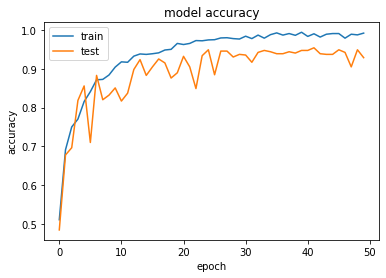

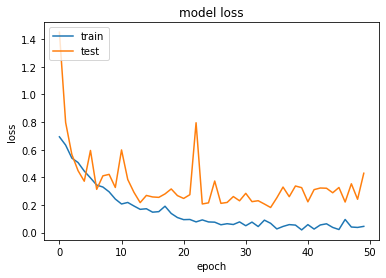

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
print(cnn_model.evaluate(test_data,test_target))

25/25 [==============================] - 0s 11ms/step - loss: 0.2604 - accuracy: 0.9466
[0.2604374885559082, 0.9466328024864197]


In [35]:
cnn_model.save('modelCovid19_1.h5')

In [37]:
pred_target=cnn_model.predict(test_data)

In [83]:
from tensorflow.keras.preprocessing import image
test_image=cv2.imread('/content/drive/MyDrive/Colab Notebooks/chest x-ray dataset/covid.jpeg')
test_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2GRAY)           
test_image=cv2.resize(test_image,(img_size,img_size))
test_image=np.array(test_image)/255.0
test_image=np.reshape(test_image,(1,img_size,img_size,1))

In [74]:
test_image.shape

(1, 100, 100, 1)

In [84]:
result=cnn_model.predict(test_image)
result

array([[0.99354494]], dtype=float32)

In [85]:
if result[0]<=0.5:
  print("The person does not have symptoms of Covid")
else:
  print("The person has symptoms of Covid")

The person has symptoms of Covid
